In [1]:
# read data
from pandas import read_csv
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
import numpy as np

df = read_csv('Ten-Year-Demand.csv',names=['year','index','x'],skiprows=1)
df=df.fillna(method='ffill')
df['year'].astype(np.int64)
df.x.plot()
pyplot.show()

<Figure size 640x480 with 1 Axes>

In [2]:
from statsmodels.tsa.stattools import adfuller as ADF
 
ADF(df['x'])

(-2.5533164709021388,
 0.10303466867288152,
 13,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 608.9355165365591)

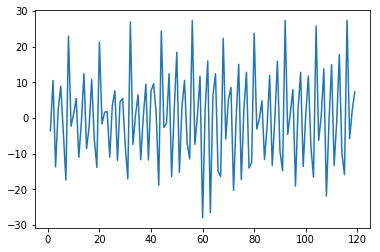

In [3]:
d_data = df.x.diff().dropna()
d_data.columns = ['order1']
d_data.plot()

In [4]:
ADF(d_data)

(-1.9380372202352032,
 0.3143841064248509,
 12,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 609.6781958694635)

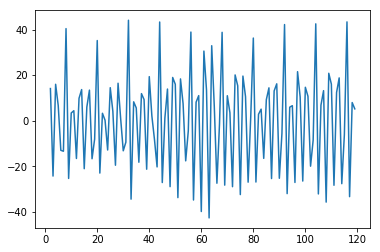

In [5]:
dd_data = d_data.diff().dropna()
dd_data.columns = ['order2']
dd_data.plot()

In [6]:
ADF(dd_data)

(-4.720614247312097,
 7.696090018465416e-05,
 13,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 601.4169839895175)

In [7]:
from statsmodels.stats.diagnostic import acorr_ljungbox
 
acorr_ljungbox(dd_data,lags =2)

(array([33.24652164, 45.67493795]), array([8.11848426e-09, 1.20729456e-10]))

D:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


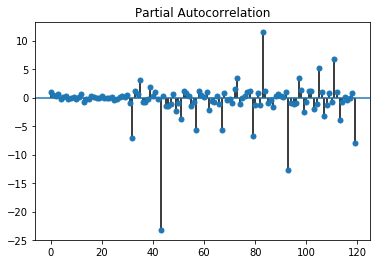

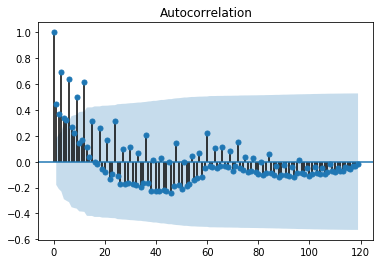

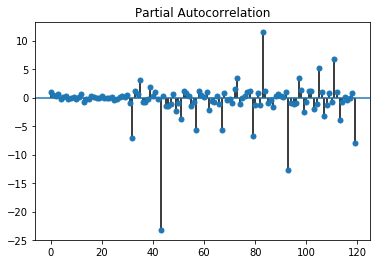

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
 
plot_acf(df.x)
plot_pacf(df.x)

D:\anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
D:\anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Month     120 non-null object
Demand    120 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


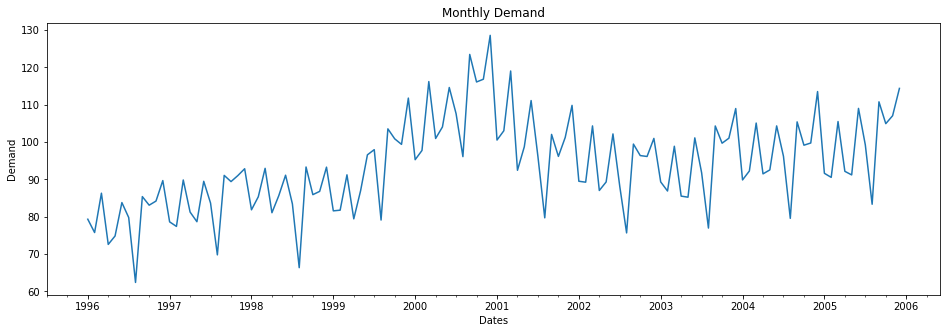

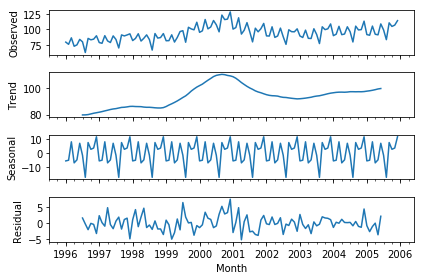

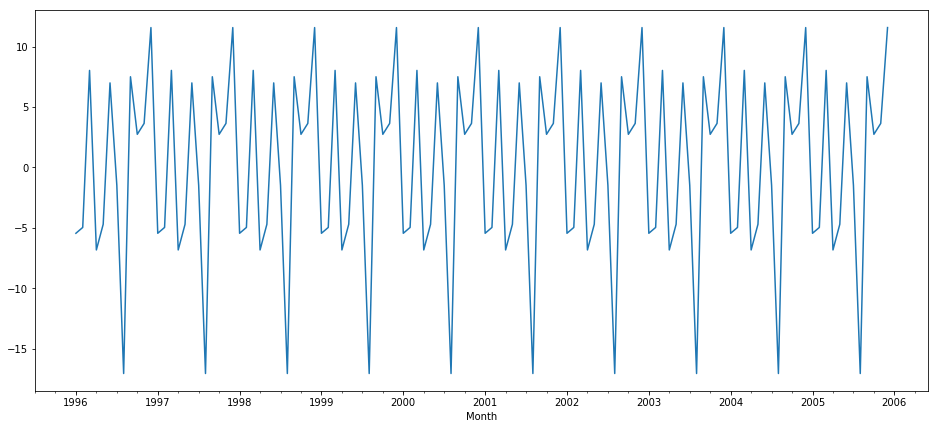

In [9]:
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


file_path = 'Demand.csv'
data = pd.read_csv(file_path)

data.info()
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index("Month")
data.head()

data.index.freq = 'MS'
ax = data['Demand'].plot(figsize = (16,5), title = "Monthly Demand")
ax.set(xlabel='Dates', ylabel='Demand');

a = seasonal_decompose(data["Demand"], model = "add")
a.plot();

plt.figure(figsize = (16,7))
a.seasonal.plot();

train_data = data[:len(data)-24]
test_data = data[len(data)-24:]

In [10]:
import warnings
from pmdarima import auto_arima

warnings.filterwarnings("ignore")

In [11]:
print(auto_arima(data['Demand'], seasonal=True, m=12, max_p=7, max_d=5, max_q=7, max_P=4,maxiter=200,max_D=4,max_Q=4,stationary=False).summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(3, 0, 2)x(0, 1, 1, 12)   Log Likelihood                -278.969
Date:                            Sat, 12 Oct 2019   AIC                            573.937
Time:                                    21:25:19   BIC                            595.394
Sample:                                         0   HQIC                           582.637
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1789      0.221      0.809      0.418      -0.254       0.612
ar.L1          0.0584      0.106   

In [12]:
arima_model = SARIMAX(train_data['Demand'], order=(3,0,2), seasonal_order=(0,1,1,12))
arima_result = arima_model.fit(maxiter=200)
arima_result.summary()
arima_predict = arima_result.predict(start = len(train_data), end=len(data)-1, typ="levels").rename("Arima Prediction")
arima_rmse_error = rmse(test_data['Demand'], arima_predict)
print(arima_rmse_error)

3.724676389936614


In [13]:
start_test = 96
test_end = 120


test_data = data[start_test:test_end]

file_path = 'Demand.csv'
data = pd.read_csv(file_path)

data.info()
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index("Month")
data.head()
prediction_thismonth = []
for i in range(start_test,test_end):
    train_data_thismonth = data[0:i]
    arima_model_thismonth = SARIMAX(train_data_thismonth['Demand'], order=(3,0,2), seasonal_order=(0,1,1,12))
    arima_result_thismonth = arima_model_thismonth.fit(maxiter=200)
    arima_predict = arima_result_thismonth.predict(start = len(train_data_thismonth),end=len(train_data_thismonth), typ="levels").rename("Arima Prediction")
    prediction_thismonth.append(arima_predict[0])
test_data["One_step_prediction"] = prediction_thismonth

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Month     120 non-null object
Demand    120 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [14]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pandas import read_csv

dataset = read_csv('Ten-Year-Demand2.csv')

In [15]:
dataset = read_csv('Ten-Year-Demand2.csv')
X = dataset[['year','time','month','average','pre1','pre2']].copy()
Y = dataset[['x']].copy()

In [16]:
X_train = X[:len(X)-24]
X_test = X[len(X)-24:]
y_train = Y[:len(Y)-24]
y_test = Y[len(Y)-24:]

In [17]:
from lightgbm import LGBMRegressor
rfreg = LGBMRegressor(boosting_type='gbdt', num_leaves=12, max_depth=-1, learning_rate=0.01, n_estimators=1000, max_bin=255, subsample_for_bin=50000, objective=None, min_split_gain=0, min_child_weight=3,min_child_samples=10, subsample=1, subsample_freq=1, colsample_bytree=1, reg_alpha=0.1, reg_lambda=0, seed=17,silent=False, nthread=-1)
rfreg.fit(X_train, y_train)
p = rfreg.predict(X_test)
y_test["prediction"]=p
rmse(y_test['prediction'],y_test['x'])

2.9243537482713404